# 6 - Data analysis
This notebook is used to integrate and analyze the geospatial, remote sensing and meteorological time series datasets.

## Setup

In [106]:
# Import libraries
import os
import datetime
from math import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [123]:
# Set working directory
os.chdir(os.path.join('E:/',
                      'McKinley'))

# Directory to store downloaded Landsat 8 data
figure_dir = os.path.join('figures')

# Check if directory exists
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

## Restore datasets

In [71]:
# Filtered seeding unit datasets
%store -r mckinley_seeding_subset_PARlo
%store -r mckinley_seeding_subset

# Smoothed Landsat 8 time series
%store -r landsat_8_time_series_rlmean 

# Met data
%store -r met_data_mckinley_df

In [72]:
landsat_8_time_series_rlmean = landsat_8_time_series_rlmean.reset_index()
landsat_8_time_series_rlmean['date'] = pd.to_datetime(landsat_8_time_series_rlmean['date'])
landsat_8_time_series_rlmean

,SuId,date,MeanNdvi
0,172,2013-05-31,NaN
1,172,2013-06-30,NaN
2,172,2013-07-31,NaN
3,172,2013-08-31,NaN
4,172,2013-09-30,NaN
...,...,...,...
4069,2650,2021-01-31,0.166747
4070,2650,2021-02-28,0.167845
4071,2650,2021-03-31,0.167633
4072,2650,2021-04-30,0.166740


## Calculate annual change in NDVI for each seeding unit

In [73]:
# Temporary list to store results
su_ndvi_annual_change = []

# Loop over each seeding unit
for i, row in mckinley_seeding_subset_PARlo.iterrows():

    # Format date from seeding unit data
    su_date = datetime.datetime.strptime(
        (str(row.Start_Year) + '-01-01'), "%Y-%m-%d")

    # Subset time series data to the seeding unit and clip to time extent of seeding unit
    su_rs_time_series = landsat_8_time_series_rlmean[(
        landsat_8_time_series_rlmean.SuId == i) & (landsat_8_time_series_rlmean.date >= su_date)]

    # Index for intervention year
    intervention_year = 0
    
    # Calculate annual change in NDVI
    # Loop over seeding unit years
    for year in su_rs_time_series.groupby(su_rs_time_series.date.dt.year):
        
        # Calculate annual change in NDVI
        ndvi_annual_change = float(year[1].MeanNdvi.tail(
            1)) - float(year[1].MeanNdvi.head(1))
        
        # Append data to list
        su_ndvi = [i, year[0], intervention_year, ndvi_annual_change]

        # Append to temporary list
        su_ndvi_annual_change.append(su_ndvi)

        # Iterate intervention year
        intervention_year += 1
        
su_ndvi_annual_change

# Convert the list to df
su_ndvi_annual_change_df = pd.DataFrame(su_ndvi_annual_change,
                                        columns=['SuId', 'Year', 'Intervention_Year', 'NDVI_delta'])
#landsat_8_ts_reformatted.set_index('SuId')

# Remove incomplete values from 2021
drop = su_ndvi_annual_change_df[su_ndvi_annual_change_df['Year'] == 2021].index
su_ndvi_annual_change_df.drop(drop, inplace=True)

su_ndvi_annual_change_df

,SuId,Year,Intervention_Year,NDVI_delta
0,172,2017,0,0.003429
1,172,2018,1,0.014250
2,172,2019,2,0.027377
3,172,2020,3,0.027374
5,816,2013,0,-0.007931
...,...,...,...,...
211,2646,2020,1,0.005811
213,2648,2019,0,-0.010371
214,2648,2020,1,0.013277
216,2650,2019,0,-0.010438


## Calculate meterological variables

In [74]:
# Resample met data to yearly values
met_data_mckinley_df = met_data_mckinley_df.resample('Y').sum()

# Add column for year
met_data_mckinley_df['year']=pd.DatetimeIndex(met_data_mckinley_df.index).year

# Remove incomplete values from 2021
drop = met_data_mckinley_df[met_data_mckinley_df['year'] == 2021].index
met_data_mckinley_df.drop(drop, inplace=True)
met_data_mckinley_df

,pr,eto,year
datetime,,,
2013-12-31,294.029337,1368.014815,2013
2014-12-31,211.298197,1464.717591,2014
2015-12-31,342.777599,1356.438671,2015
2016-12-31,274.456320,1436.707471,2016
2017-12-31,246.700000,1507.600001,2017
2018-12-31,233.299999,1548.700000,2018
2019-12-31,283.499999,1417.999998,2019
2020-12-31,192.700000,1583.600001,2020


## Add meteorological variables to seeding unit df

In [75]:
# Create dictionary of years and precipitation values
precip_dict = dict(zip(met_data_mckinley_df.year, met_data_mckinley_df.pr))

# Map the precipitation values to the seeding units
su_ndvi_annual_change_df['precip'] = su_ndvi_annual_change_df['Year'].map(precip_dict)
su_ndvi_annual_change_df

,SuId,Year,Intervention_Year,NDVI_delta,precip
0,172,2017,0,0.003429,246.700000
1,172,2018,1,0.014250,233.299999
2,172,2019,2,0.027377,283.499999
3,172,2020,3,0.027374,192.700000
5,816,2013,0,-0.007931,294.029337
...,...,...,...,...,...
211,2646,2020,1,0.005811,192.700000
213,2648,2019,0,-0.010371,283.499999
214,2648,2020,1,0.013277,192.700000
216,2650,2019,0,-0.010438,283.499999


## Create plots

### Plot of annual precipitation

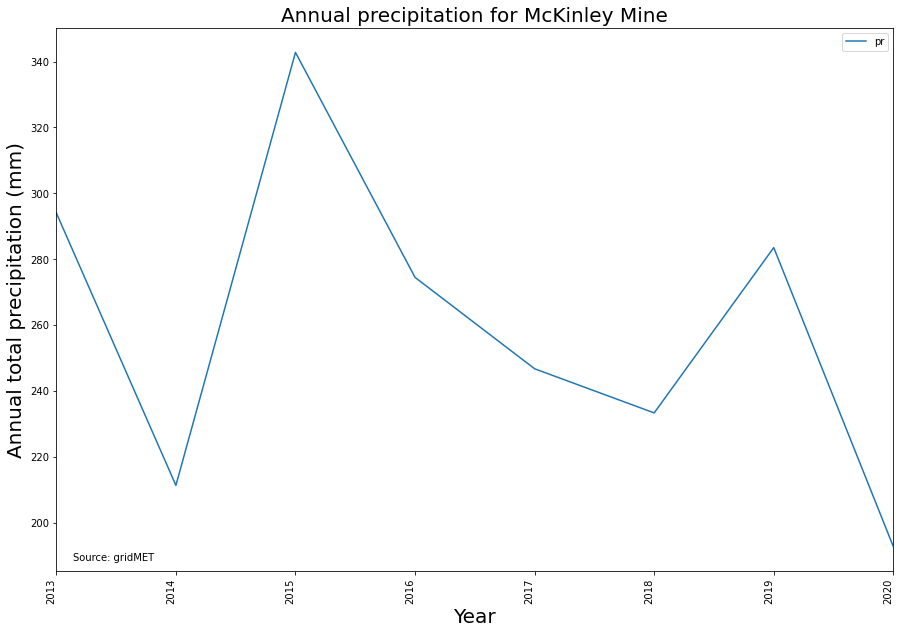

In [82]:
fig, ax = plt.subplots(figsize=(15, 10))

met_data_mckinley_df.plot(y='pr', ax=ax)

ax.set_title(
    "Annual precipitation for McKinley Mine", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xlabel("Year", fontsize=20)
plt.ylabel("Annual total precipitation (mm)", fontsize=20)
ax.text(.02, .02, "Source: gridMET", transform=ax.transAxes, color="black")

plt.show()

### Plots of seeding unit data

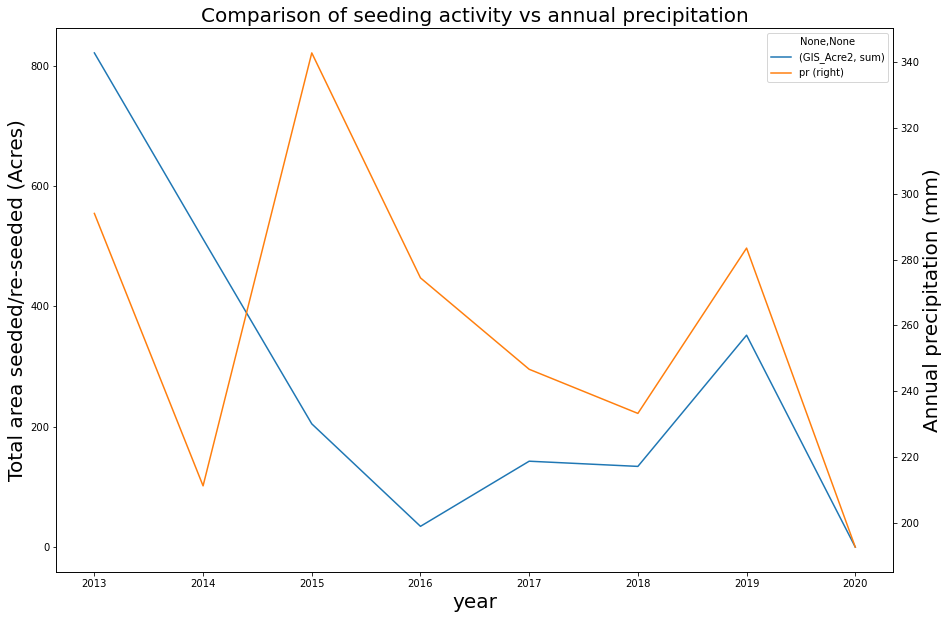

In [79]:
# Setup plots
fig, ax = plt.subplots(figsize=(15, 10))

#legend_items = ['Filtered seeding units', 'Annual precipitation']

# Plot acreage seeded/re-seeded per year
mckinley_seeding_subset.groupby('Start_Year').agg({'GIS_Acre2': ['sum']}).plot(ax=ax)


plt.xlabel("Year", fontsize=20)
plt.ylabel("Total area seeded/re-seeded (Acres)", fontsize=20)

# Plot annual precipitation
met_data_mckinley_df.plot(x='year', y='pr', ax=ax, secondary_y=True)

ax.set_title(
    "Comparison of seeding activity vs annual precipitation", fontsize=20)

plt.ylabel("Annual precipitation (mm)", fontsize=20)


plt.show()

In [57]:
mckinley_seeding_subset_PARlo.groupby('Start_Year').agg({'GIS_Acre2': ['sum']})

,GIS_Acre2
,sum
Start_Year,
2013,381.136017
2014,207.544611
2015,7.430665
2017,105.093995
2018,85.090088
2019,237.893200


### Plot of annual NDVI change against precipitation for the different seeding units

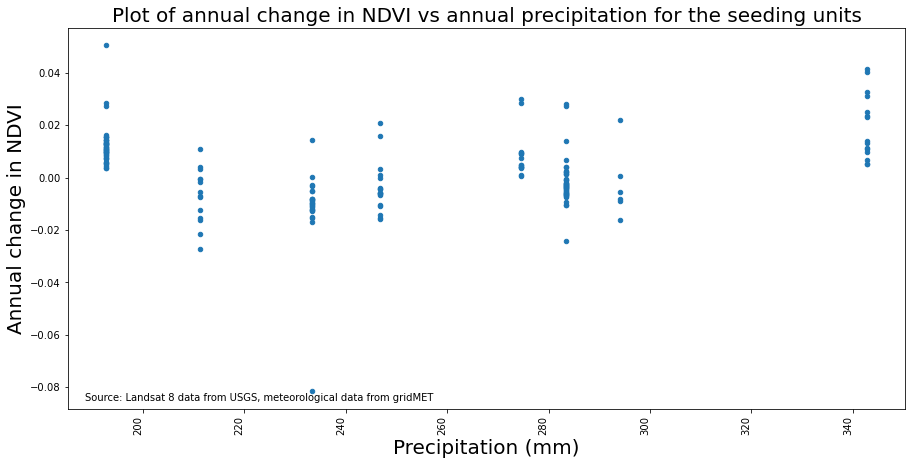

In [128]:
fig, ax = plt.subplots(figsize=(15, 7))

su_ndvi_annual_change_df.plot.scatter(y='NDVI_delta', x='precip', ax=ax)

ax.set_title(
    "Plot of annual change in NDVI vs annual precipitation for the seeding units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xlabel("Precipitation (mm)", fontsize=20)
plt.ylabel("Annual change in NDVI", fontsize=20)
ax.text(.02, .02, "Source: Landsat 8 data from USGS, meteorological data from gridMET",
        transform=ax.transAxes, color="black")

plt.savefig(os.path.join(figure_dir,'mckinley_annual_ndvi_change_vs_precipitation.png'), dpi=150)
plt.show()

### Plot of annual NDVI change vs year for the seeding units

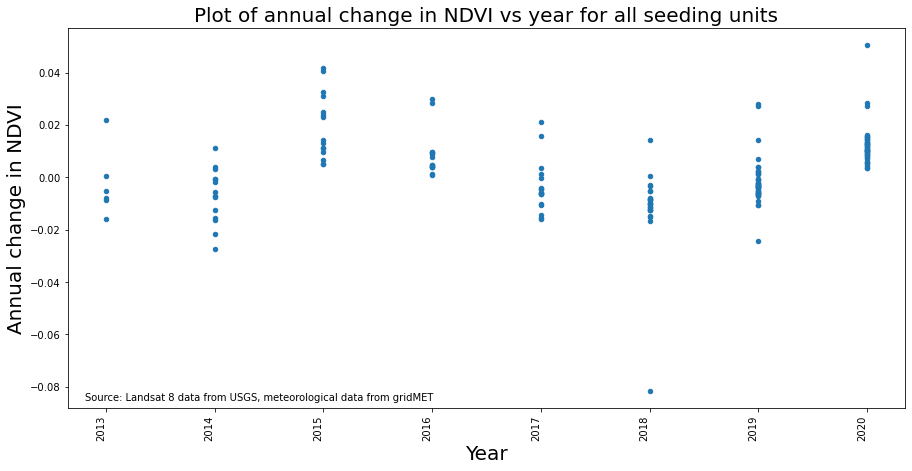

In [126]:
fig, ax = plt.subplots(figsize=(15, 7))

su_ndvi_annual_change_df.plot.scatter(y='NDVI_delta', x='Year', ax=ax)

ax.set_title(
    "Plot of annual change in NDVI vs year for all seeding units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xlabel("Year", fontsize=20)
plt.ylabel("Annual change in NDVI", fontsize=20)
ax.text(.02, .02, "Source: Landsat 8 data from USGS, meteorological data from gridMET",
        transform=ax.transAxes, color="black")

plt.savefig(os.path.join(figure_dir,'mckinley_annual_ndvi_change_vs_year.png'), dpi=150)
plt.show()


### Plot of annual NDVI change vs intervention year for the seeding units

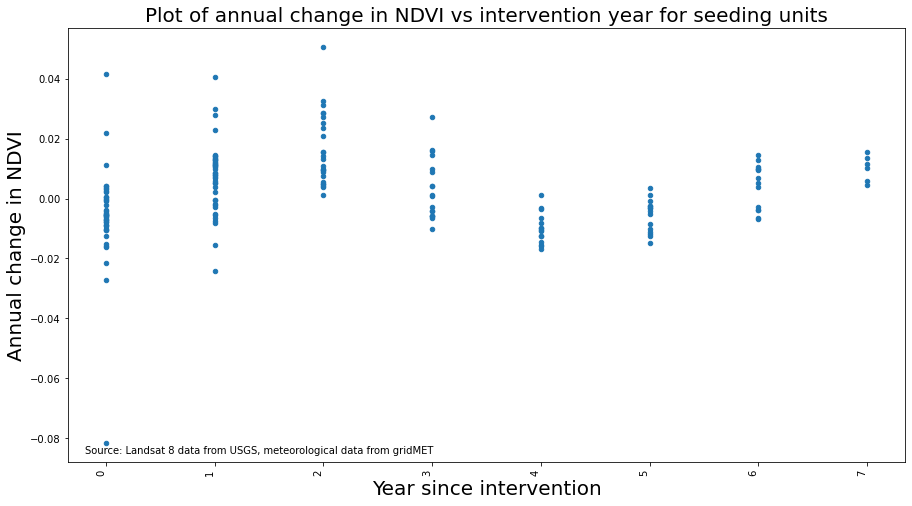

In [121]:
fig, ax = plt.subplots(figsize=(15, 8))

su_ndvi_annual_change_df.plot.scatter(y='NDVI_delta', x='Intervention_Year', ax=ax)

ax.set_title(
    "Plot of annual change in NDVI vs intervention year for seeding units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.xlabel("Year since intervention", fontsize=20)
plt.ylabel("Annual change in NDVI", fontsize=20)
ax.text(.02, .02, "Source: Landsat 8 data from USGS, meteorological data from gridMET",
        transform=ax.transAxes, color="black")

plt.show()

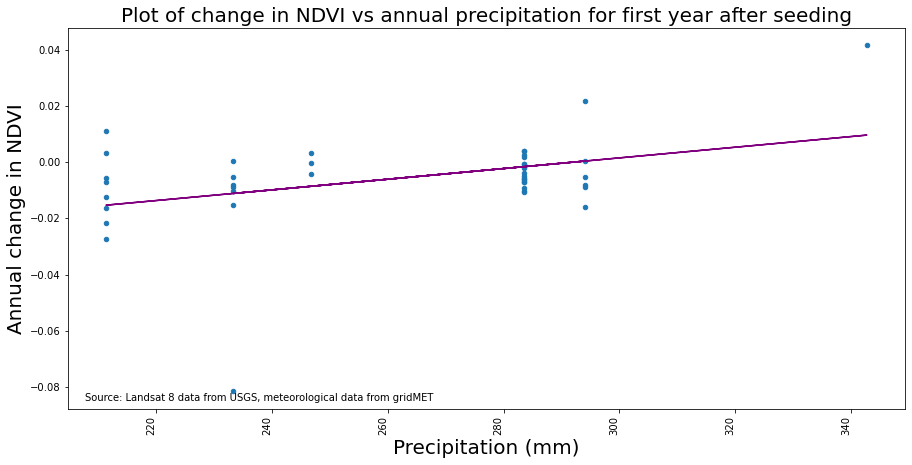

slope: 0.00018976824463687075 
intercept: -0.055368091355594326 
r squared: 0.1574338583252351 
p-value: 0.009279447628931747 
st_error 6.941390494257364e-05 
RMSE 0.008331500761721962


In [130]:
# Plot of annual change in NDVI vs precipitation for intervention year 0
fig, ax = plt.subplots(figsize=(15, 7))

year = 0

su_ndvi_annual_change_df[su_ndvi_annual_change_df['Intervention_Year'] == year].plot.scatter(
    y='NDVI_delta', x='precip', ax=ax)

# Add regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(su_ndvi_annual_change_df[su_ndvi_annual_change_df['Intervention_Year'] == year].precip,
                                                               su_ndvi_annual_change_df[su_ndvi_annual_change_df['Intervention_Year'] == year].NDVI_delta)

ax.plot(su_ndvi_annual_change_df[su_ndvi_annual_change_df['Intervention_Year'] == year].precip, intercept + slope*su_ndvi_annual_change_df[su_ndvi_annual_change_df['Intervention_Year'] == year].precip, 'grey', label='regression fitted line',
        color="purple")

ax.set_title(
    "Plot of change in NDVI vs annual precipitation for first year after seeding", fontsize=20)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.xlabel("Precipitation (mm)", fontsize=20)
plt.ylabel("Annual change in NDVI", fontsize=20)
ax.text(.02, .02, "Source: Landsat 8 data from USGS, meteorological data from gridMET",
        transform=ax.transAxes, color="black")

plt.savefig(os.path.join(figure_dir,'mckinley_annual_ndvi_change_vs_precipitation_year0.png'), dpi=150)
plt.show()

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np-value:", p_value,
      "\nst_error", std_err,
      "\nRMSE", sqrt(std_err))

## Data analysis

### Ideas
- Plot of change in NDVI since seeding/re-seeding; i.e. year one, year two etc...
- Plot comparing NDVI change for seeding and re-seeding units; what is impact of different actions?

## Store the output

In [ ]:
#%store landsat_8_time_series_rlmean